In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import networkx as nx
import torch_geometric
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
import matplotlib.pyplot as plt


Data(x=[5000, 2000], edge_index=[2, 22736], block=[5000], partition=[2], name='stochastic_block_model')


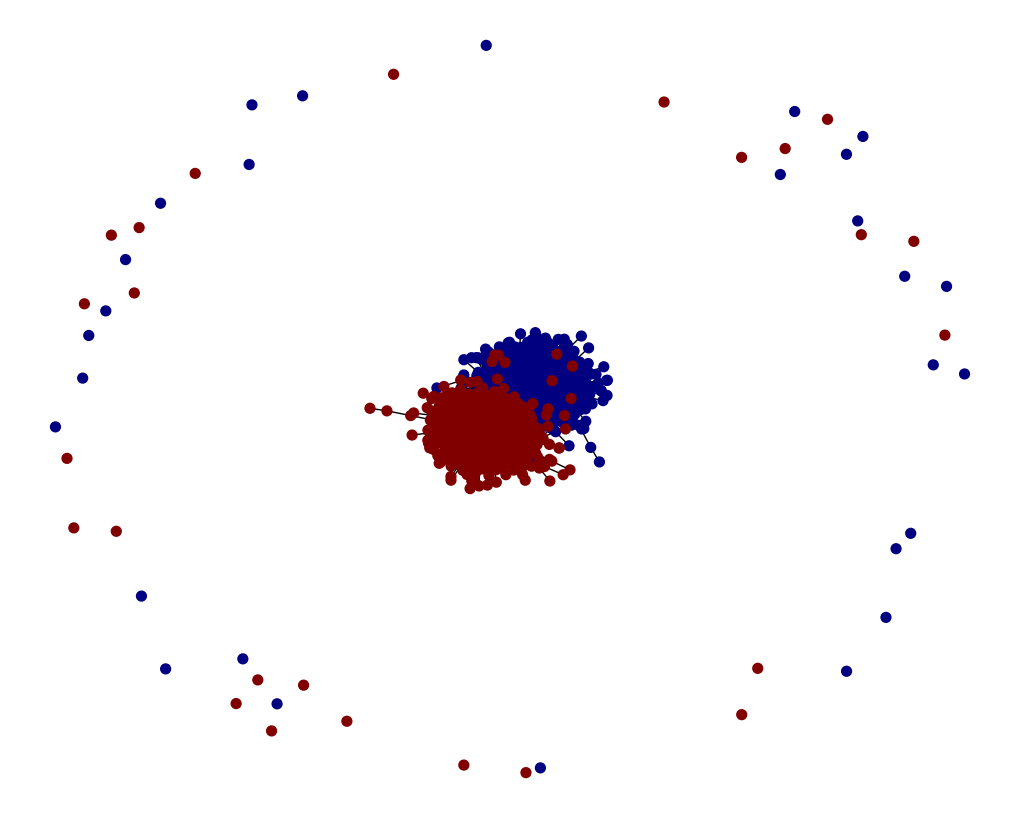

In [15]:
def generate_cSBM(n = 5000, f = 2000, d = 5, l = 2.06, mu = 2.0, censor_fraction=0.1):
    """
    Generate a cSBM dataset.

    Parameters:
    - n: Number of nodes in the graph.
    - f: Number of features for each node.
    - d: Average degree of each node.
    - l: Signal-to-noise ratio.
    - mu: Signal strength.
    - censor_fraction: Fraction of edges to censor.

    Returns:
    - PyTorch Geometric Data object representing the censored graph.
    """
    
    # Generate SBM graph
    nodes_per_community = n // 2
    sizes = [nodes_per_community] * 2
    ksi = n / f
    phi = 2 / np.pi * np.arctan(l * np.sqrt(ksi) / mu)
    p_in = (d + l * np.sqrt(d)) / n
    p_out = (d - l * np.sqrt(d)) / n
    p_matrix = np.ones((2, 2)) * p_out
    np.fill_diagonal(p_matrix, p_in)
    G = nx.stochastic_block_model(sizes, p_matrix)
    
    # Censor edges
    all_edges = list(G.edges())
    np.random.shuffle(all_edges)
    edges_to_remove = all_edges[:int(censor_fraction * len(all_edges))]
    G.remove_edges_from(edges_to_remove)
    
    # Add node features
    for node in G.nodes():
        u = np.random.normal(0, 1 / f, f)
        y = G.nodes[node]['block']
        Z = np.random.normal(0, 1, f)
        G.nodes[node]['x'] = np.sqrt(mu / n) * y * u + Z / np.sqrt(f)
    
    # Convert to PyTorch Geometric format
    data = from_networkx(G)
    
    # Constructing the feature tensor
    node_features = [G.nodes[node]['x'] for node in G.nodes()] # Ensure that the feature vectors are correctly shaped and then stack them
    data.x = torch.tensor(node_features, dtype=torch.float)
    
    return data, G

# Generate cSBM data and the networkx graph
cSBM_data, G = generate_cSBM()
print(cSBM_data)

# Visualization
def visualize_graph(G):
    # Get the community of each node for coloring
    community_map = {node: G.nodes[node]['block'] for node in G.nodes()}
    colors = [community_map[node] for node in G.nodes()]
    
    plt.figure(figsize=(10, 8))
    nx.draw(G, node_color=colors, with_labels=False, node_size=50, cmap=plt.cm.jet)
    plt.show()

visualize_graph(G)